### Использованные библиотеки

In [1]:
!pip install -q -r requirements.txt

### Часть 3

На самом деле у меня нет каких-то прорывных идей по улучшению, потому что я не математик, и в тему я не так сильно погружён. Но можно хотя бы попробовать проанализировать другие двергенции и подумать, могут ли они нам как-то помочь. Какие-то можно легко найти, какие-то надо поискать, но их ещё есть немало. Я сразу скажу, что я не знаю их свойств, и не знаю, в каких ситуациях они применимы, но попробовать имеет смысл все, в любом случае. Ниже список других возможных $f$-функций и их производных. Все их я тоже реализовал и засунул в `utils.py`

$$
\begin{array}{lllc}
\hline f \text {-divergence } & \boldsymbol{f}(\boldsymbol{u}) & \boldsymbol{f}^{\prime}(\boldsymbol{u}) \\
\hline
\text { Pearson } \chi^2 & (u-1)^2 & 2(u-1)\\
\text { Neyman } \chi^2 & (1-u)^2 / u & 1 - \frac{1}{u^2}\\
\text { CNP }  \chi^2 & \frac{1}{3} \left(2\chi^2_{\text{Pearson}} + \chi^2_{\text{Neyman}} \right) & \frac{1}{3} \left( 4u - 3 - \frac{1}{u^2}\right)\\
\text { Hellinger } & (\sqrt{u}-1)^2 & 1 - \frac{1}{\sqrt{u}}\\
\text { Jeffrey } & (u-1)\log{u} &  \log u + 1 - \frac{1}{u}\\
\text { GAN } & u\log{u} - (u+1)\log(u+1) & \log u - \log(u+1)\\
\text { Total Variation } & \frac{1}{2}|u-1| & u>1 ? \frac{1}{2}:-\frac{1}{2}\\
\chi^{\alpha} \ \text {distance} \ (\alpha > 1) & \frac{1}{2}|u-1|^{\alpha} & u>1 ? \frac{\alpha(u-1)^{\alpha-1}}{2}:-\frac{\alpha(1-u)^{\alpha-1}}{2}\\
\hline
\end{array}
$$

In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import torch

from utils import *
from pipeline import (
    Pipeline, train_loop_for_divs, 
    mean_summary_plot, agg_experiments
)

from tqdm.auto import tqdm, trange
from IPython.display import clear_output, display, HTML
import plotly.graph_objects as go
import plotly

plotly.offline.init_notebook_mode()
display(HTML(
    '<script type="text/javascript" async src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/MathJax.js?config=TeX-MML-AM_SVG"></script>'
))

import gc
from glob import glob

divs = [
    pearson_chi2, neyman_chi2,
    hellinger_distance, jeffrey_distance,
    GAN_distance, total_variation_distance,
    cnp_chi2, chi_alpha
]
names = [
    "pearson", "neyman",
    "hellinger", "jeffrey",
    "GAN", "TVD",
    "cnp", "chi_alpha"
]

Трейн выглядит аналогично, только названия другие

In [2]:
train_loop_for_divs(divs, names, n_trials=5)

hellinger trained


И вот, что получается после экспериментов

In [2]:
agg_experiments(names).T

,0,1,2,3,4,5,6
experiment,tvd,neyman,pearson,cnp,hellinger,jeffrey,GAN
reward,-0.144466,0.772483,1.494495,1.864848,1.91639,2.052727,2.109785
diversity,5.634269,5.633501,5.783702,5.742292,5.376369,4.548025,5.268793
sigma_reward,0.463946,0.684058,0.816752,0.865861,0.871735,0.886223,0.891851


Как можно видеть, многие лоссы в общем-то не самые плохие, некоторые явно лучше остальных, если судить по балансу diversity-reward. Посмотрим на них на графике. TVD и neyman сразу отбросим, по ним видно, что качество слишком плохое

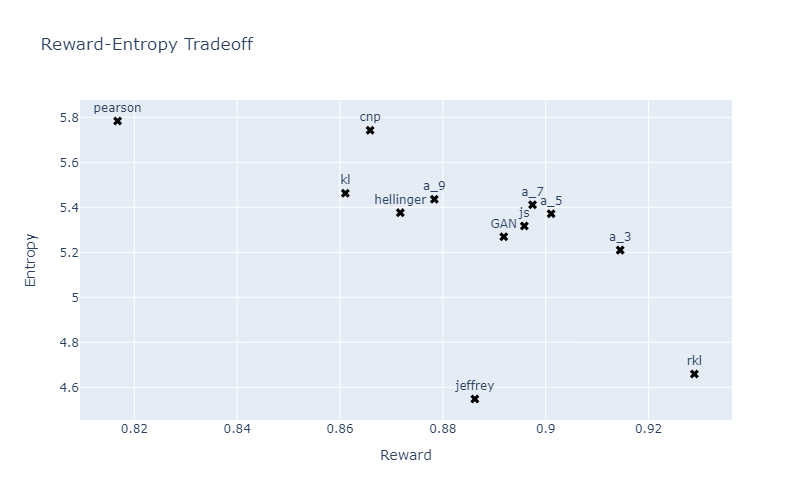

In [2]:
names = [
    "a_3", "a_5", "a_7", "a_9",
    "pearson", # "neyman",
    "hellinger", "jeffrey",
    "GAN", # "TVD",
    "cnp", "chi_alpha",
    "kl", "rkl", "js",
]

summary = agg_experiments(names)
mean_summary_plot(summary, polyfit=False)

И тут на самом деле всё равно довольно сложно сказать. Выделяется cnp тем, что сильно увеличивает дайвёрсити, при этом сохраняя реворд КЛ-дивергенции. Это не самые позитивные отзывы, да, но по какой-то причине очень разнообразные

Ещё можно попробовать взять другие лоссы. Мы пробовали только `hinge` и `sigmoid`, но `DPOTrainer` поддерживает ещё `ipo`, а также есть [отчёт](https://github.com/ContextualAI/HALOs/tree/main) про модернизацию этой штуки с лоссом `kto`, их я тоже уже встроил, там немного. Дивергенцию я буду брать ту, которая мне больше всего понравилась

In [2]:
div = lambda x, y: alpha_divergence(x, y, 0.5)

In [ ]:
for loss in ["ipo", "kto"]:
    for i in trange(5):
        pipe = Pipeline()
        pipe.train(loss_type=loss, n_samples=100, random_state=i)
        pipe.evaluate(f"{loss}_{i}", n_samples=100)

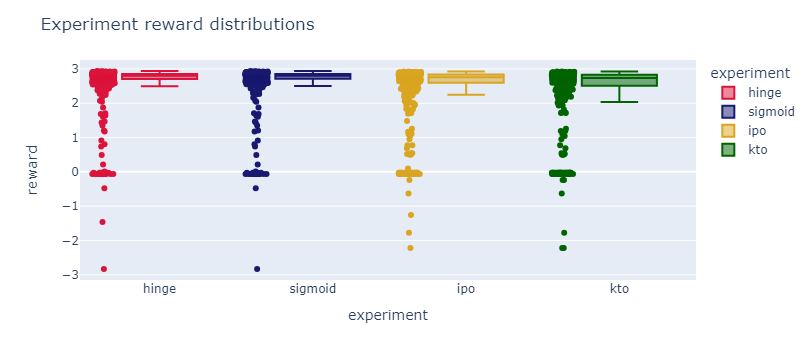

In [3]:
import plotly.express as px

names = ["hinge", "sigmoid", "ipo", "kto"]
summary = agg_experiments(names, agg=False)

fig = px.box(
    summary, y="reward", x="experiment", color="experiment", points="all",
    color_discrete_sequence=["crimson", "midnightblue", "goldenrod", "darkgreen"]
)
fig.update_layout(title="Experiment reward distributions")
fig.show()

К сожалению или к счастью, альтернативные лоссы ничего особенного не дают с точки зреняи качество. Всё равно всё в целом на одном уровне

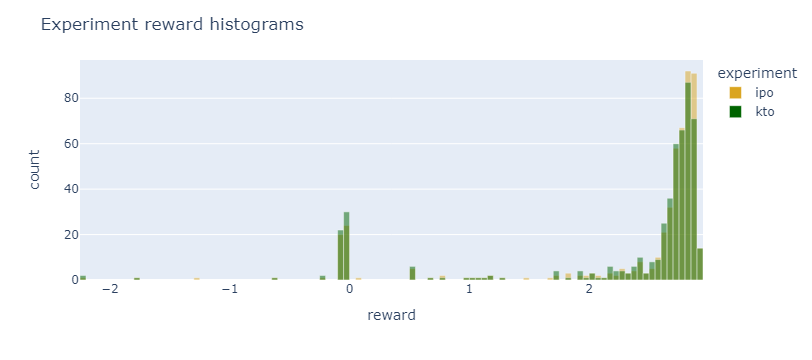

In [4]:
import plotly.express as px

sub_df = summary[summary.experiment.isin(["ipo", "kto"])]
fig = px.histogram(
    sub_df, x="reward", color="experiment",
    nbins=150, opacity=0.5, barmode="overlay",
    color_discrete_sequence=["goldenrod", "darkgreen"]
)
fig.update_layout(title="Experiment reward histograms")
fig.update_traces(marker_line_width=0.5 ,marker_line_color="white")
fig.show()

Если же сравнивать только новые лоссы, они всё равно оказываются уж очень похожими. По сравнению со своими конкурентами, их результаты получаются немного разнообразнее, возможно, это плюс, но на явное улучшение, к сожалению, не тянет 